In [1]:
import psana as ps
import numpy as np
ds = ps.DataSource('exp=xppx37817:run=504:smd')

In [2]:
!hostname

psanagpu114


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
print(ps.DetNames())
jungfrau=ps.Detector('jungfrau1M')

[('XppEndstation.0:Jungfrau.0', 'jungfrau1M', ''), ('NoDetector.0:Evr.1', 'evr1', ''), ('NoDetector.0:Evr.0', 'evr0', ''), ('EBeam', '', ''), ('PhaseCavity', '', ''), ('FEEGasDetEnergy', '', ''), ('XppEnds_Ipm0', '', ''), ('XPP-AIN-01', '', ''), ('HX2-SB1-BMMON', '', ''), ('XPP-USB-ENCODER-01', '', ''), ('XPP-SB2-BMMON', '', ''), ('XPP-SB3-BMMON', '', ''), ('XppGon.0:Epix100a.1', 'epix_1', ''), ('ControlData', '', '')]


In [5]:
#f,ax1=plt.subplots(1)
#plt.rcParams['figure.figsize'] = 10, 10
ss=[]
images=[]
m=0
c=0

for n,evt in enumerate(ds.events()):
        image=jungfrau.image(evt)

        if image is not None:
            s=np.sum(image)
            ss.append(s)
            if s>3e6:
                m=m+image
                c+=1
                images.append(image)
        else:
            ss.append(0)
        if n%100==0: print(n,c)

/reg/neh/home/zimmf/.conda/envs/local2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(0, 1)
(100, 75)
(200, 140)
(300, 214)
(400, 286)
(500, 358)
(600, 413)
(700, 466)
(800, 529)
(900, 592)
(1000, 653)
(1100, 716)
(1200, 774)
(1300, 844)
(1400, 908)
(1500, 974)
(1600, 1019)
(1700, 1019)
(1800, 1019)
(1900, 1081)
(2000, 1153)
(2100, 1223)
(2200, 1291)
(2300, 1357)
(2400, 1416)
(2500, 1485)
(2600, 1534)
(2700, 1599)
(3200, 1916)
(3300, 1976)
(3400, 2043)
(3500, 2117)
(3600, 2176)
(3700, 2212)
(3800, 2218)
(3900, 2287)
(4000, 2352)
(4100, 2422)
(4200, 2495)
(4300, 2564)
(4400, 2636)
(4500, 2697)
(4600, 2758)
(4700, 2819)
(4800, 2880)
(4900, 2943)
(5000, 3004)
(5100, 3067)
(5200, 3145)
(5300, 3213)
(5400, 3280)
(5500, 3347)
(5600, 3407)
(5700, 3411)
(5800, 3451)
(5900, 3522)
(6000, 3594)
(6100, 3660)
(6200, 3732)
(6300, 3797)
(6400, 3873)
(6500, 3941)
(6600, 4006)
(6700, 4078)
(6800, 4152)
(6900, 4220)
(7000, 4285)
(7100, 4349)
(7200, 4414)
(7300, 4490)
(7400, 4552)
(7500, 4611)
(7600, 4659)
(7700, 4659)
(7800, 4659)
(7900, 4659)
(8000, 4729)
(8100, 4785)
(8200, 4850)
(830

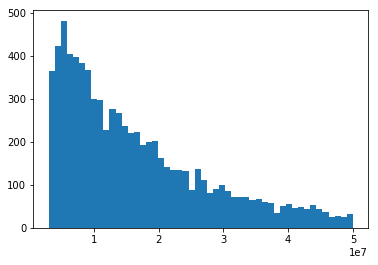

In [6]:
%matplotlib inline
plt.hist(np.array(ss),range=[3e6,5e7],bins=50);

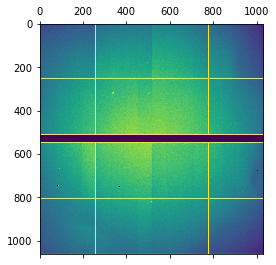

In [7]:
plt.matshow(m,vmin=10*c,vmax=30*c)

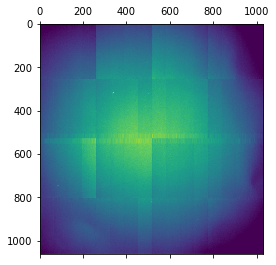

In [8]:
from scipy import ndimage as nd
import scipy.signal as ss

def fill(data, invalid=None):
    if invalid is None: invalid = np.isnan(data)
    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]


def getmask(evt):
    #get increased mask
    mask=jungfrau.image(evt,nda_in=jungfrau.mask_geo(evt)).astype(bool)
    el=np.zeros([3,3])
    el[...,1]=1
    return ~nd.morphology.binary_dilation(~(mask.astype(bool)),el,iterations=3)

def fixmasked(inp,mask):
    #fill masked
    ret=inp.copy()
    ret[~mask.astype(bool)]=np.nan
    ret=fill(ret)

    #medianfilter
    ret=ss.medfilt2d(ret,3)
    return ret

mask=getmask(evt)
plt.matshow(fixmasked(m,mask),vmax=30*c,vmin=15*c)

In [9]:
import numba
import numpy as np
@numba.jit
def find_center(img,msk,x0=0,y0=0,maxr=500,d=60):
    id=jit_find_center(img,msk.astype(bool),int(x0),int(y0),int(maxr),int(d))
    return np.unravel_index(id,(2*d+1,2*d+1))-np.array([d,d])

@numba.njit(parallel=True)
def jit_find_center(img,msk,x0,y0,maxr,d):
    sx,sy=img.shape
    out=np.empty((2*d+1,2*d+1))
    for xs in numba.prange(x0-d,x0+d+1,1):
        for ys in xrange(y0-d,y0+d+1,1):
            cx=sx//2+xs
            cy=sy//2+ys
            rx=min(cx,sx-cx,maxr)
            ry=min(cy,sy-cy,maxr)
            err=0
            cn=0
            for x in xrange(-rx+1,0):
                for y in xrange(-ry+1,ry):
                    if msk[cx+x,cy+y]==1 and msk[cx-x,cy-y]==1:
                        cn+=1
                        err+=abs(img[cx+x,cy+y]-img[cx-x,cy-y])
            out[xs+d,ys+d]=err/cn
    return out.argmin()

In [10]:
%%time
offset=find_center(fixmasked(m,mask),mask)
print(offset)

[-19 -31]
CPU times: user 34.5 s, sys: 590 ms, total: 35.1 s
Wall time: 5.56 s


[-19 -31]


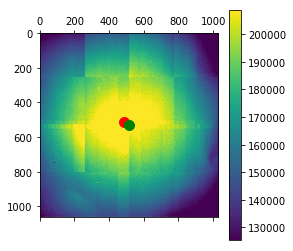

In [11]:
print(offset)
center=np.array(m.shape)//2+np.array(offset)
plt.matshow(fixmasked(m,mask),vmin=c*15,vmax=c*25)
plt.colorbar()
plt.scatter(center[1], center[0], s=100, c='red', marker='o')
plt.scatter(m.shape[1]//2, m.shape[0]//2, s=100, c='green', marker='o')

In [9]:
def offsetpad(inp,offsets):
    pad=[(0,0)]*(inp.ndim-len(offsets)) + [(-2*offset if offset<0 else 0, 2*offset if offset>0 else 0) for offset in offsets]
    return np.pad(inp,pad,mode='constant')


In [ ]:
mpad=offsetpad(m,offset)
maskpad=offsetpad(mask,offset)
mpad.shape

In [17]:
images=np.array(images)

In [19]:
np.save("xpp/scratch/zimmf/run504.npy",images)

In [20]:
np.savez("xpp/scratch/zimmf/run504-other.npy",mpad=mpad,maskpad=maskpad,offset=offset)

In [6]:
other=np.load("xpp/scratch/zimmf/run504-other.npy.npz")

In [7]:
mpad=other['mpad']
maskpad=other['maskpad']
offset=other['offset']

In [4]:
images=np.load("xpp/scratch/zimmf/run504.npy")

In [11]:
images.shape

(8356, 1064, 1030)

In [13]:
images=offsetpad(np.array(images[:3000,...]),offset)
np.multiply(images,maskpad[None,...],out=images);
print(images.shape)

(3000, 1102, 1092)


In [14]:
pixelsize=75*1e-6
detz=10*1e-2
z=detz/pixelsize

In [15]:
import idi.reconstruction as recon
from imp import reload
recon.ft=reload(recon.ft)

In [ ]:
%%time
t=recon.ft.corr(images,z)

In [ ]:
c=8356
norm=recon.ft.corr(mpad*maskpad/c,z)

In [ ]:
c=images.shape[0]
np.multiply(norm,c,out=norm)
res=np.divide(t,norm);


In [ ]:
import scipy.ndimage
omask=norm<1e12
omask=scipy.ndimage.morphology.binary_dilation(omask,scipy.ndimage.morphology.generate_binary_structure(3,3),iterations=1)

In [ ]:
res[omask]=0
m=np.mean(res[~omask])
np.subtract(res,max(1,m),out=res)
res=np.nan_to_num(res,copy=False)

In [ ]:
res=np.roll(res,shift=(res.shape[1]//2,res.shape[2]//2),axis=(1,2))

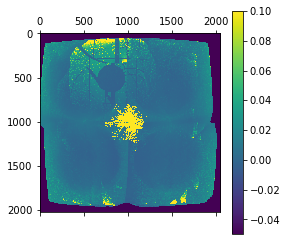

In [33]:
plt.matshow(np.max(res[0:100,...],axis=0),vmin=-0.05,vmax=.1)
plt.colorbar()
plt.savefig("504.png",dpi=1200)

In [85]:
res[omask]=0
m=np.mean(res[~mask])
np.subtract(res,max(1,m),out=res)
res=np.nan_to_num(res,copy=False)
np.multiply(res,255,out=res)
res=np.roll(res,shift=(res.shape[1]//2,res.shape[2]//2),axis=(1,2))
res=bin(res,np.array(res.shape)//np.array((1,2,2)),'max')
np.clip(res,0,255,out=res);


369

In [89]:
res=np.roll(res,shift=(res.shape[1]//2,res.shape[2]//2),axis=(1,2))

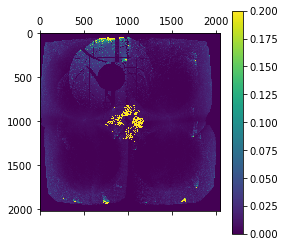

In [43]:
plt.matshow((np.nanmax(np.nan_to_num(res[20:100,...]),axis=0)),vmin=-0,vmax=0.2)
plt.colorbar()